In [22]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
EOSINOPHIL_PATH = '../input/white-blood-cell-dataset/data/EOSINOPHIL/*.jpg'
LYMPHOCYTE_PATH = '../input/white-blood-cell-dataset/data/LYMPHOCYTE/*.jpg'
MONOCYTE_PATH = '../input/white-blood-cell-dataset/data/MONOCYTE/*.jpg'
NEUTROPHIL_PATH = '../input/white-blood-cell-dataset/data/NEUTROPHIL/*.jpg'

EOSINOPHIL_LABEL = 0
LYMPHOCYTE_LABEL = 1
MONOCYTE_LABEL   = 2
NEUTROPHIL_LABEL = 3

In [26]:
CELL_TYPES = {
    "EOSINOPHIL": 0,
    "LYMPHOCYTE": 1,
    "MONOCYTE": 2,
    "NEUTROPHIL": 3
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
class Data(Dataset):
    def __init__(self, img_size_w = 224, img_size_h = 224, up_sample=True, mode = 'train'):
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h
        self.mode = mode

        self.load_data(up_sample)
        self.split_data()

    def set_mode(self, mode):
        self.mode = mode

    def set_transformers(self, train_transform=None, val_transform=None):
        pass
        
    def split_data(self):
        pass

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
        elif self.mode == 'test':
            return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_val[idx], self.y_val[idx]
            image = self.val_transform(image)
        elif self.mode == 'test':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images / 255.0

    def load_from_dataset(self, path):
        data = []
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(self.img_size_w, self.img_size_h))
            data.append(img)
        return data
    
    def load_data(self, up_sample):
        eosinophil = self.load_from_dataset(EOSINOPHIL_PATH)
        lymphocyte = self.load_from_dataset(LYMPHOCYTE_PATH)
        monocyte   = self.load_from_dataset(MONOCYTE_PATH)
        neutrophil = self.load_from_dataset(NEUTROPHIL_PATH)

        eosinophil = np.array(eosinophil, dtype=np.float32)
        lymphocyte = np.array(lymphocyte, dtype=np.float32)
        monocyte   = np.array(monocyte,   dtype=np.float32)
        neutrophil = np.array(neutrophil, dtype=np.float32)

        print (f'dataset shape is : {monocyte.shape}')

        eosinophil_labels = np.full(eosinophil.shape[0], CELL_TYPES["EOSINOPHIL"])
        lymphocyte_labels = np.full(lymphocyte.shape[0], CELL_TYPES["LYMPHOCYTE"])
        monocyte_labels   = np.full(monocyte.shape[0],   CELL_TYPES["MONOCYTE"])
        neutrophil_labels = np.full(neutrophil.shape[0], CELL_TYPES["NEUTROPHIL"])
        
        images = (eosinophil, lymphocyte, monocyte, neutrophil)
        labels = (eosinophil_labels, lymphocyte_labels, monocyte_labels, neutrophil_labels)
        self.images = np.concatenate(images, axis=0)
        self.labels = np.concatenate(labels, axis=0)

        self.show_sample_images([eosinophil[0], lymphocyte[0], monocyte[0], neutrophil[0]])

    def show_sample_images(self, sample_images): 
        reverse_cell_types = {v: k for k, v in CELL_TYPES.items()} 
        plt.figure(figsize=(10, 10)) 
        for i in range(len(sample_images)): 
            plt.subplot(1, len(sample_images), i + 1) 
            plt.imshow(sample_images[i].astype('uint8')) 
            plt.title(f'Label: {reverse_cell_types.get(i, "Unknown")}')
            plt.axis('off')

    def plot_label_distribution(self): 
        label_counts = {k: np.sum(self.labels == v) for k, v in CELL_TYPES.items()} 
        plt.figure(figsize=(10, 5)) 
        plt.bar(label_counts.keys(), label_counts.values()) 
        plt.xlabel('Cell Type') 
        plt.ylabel('Count') 
        plt.title('Distribution of Cell Types in Dataset')

dataset shape is : (20, 28, 28, 3)


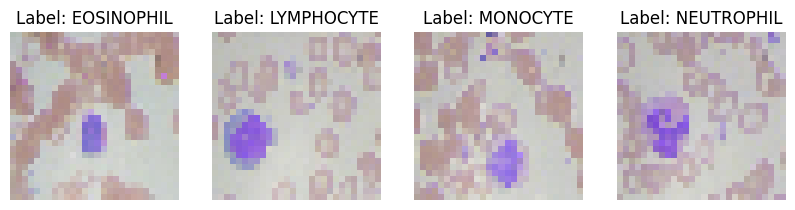

In [33]:
dataset = Data(img_size_w=28, img_size_h=28)

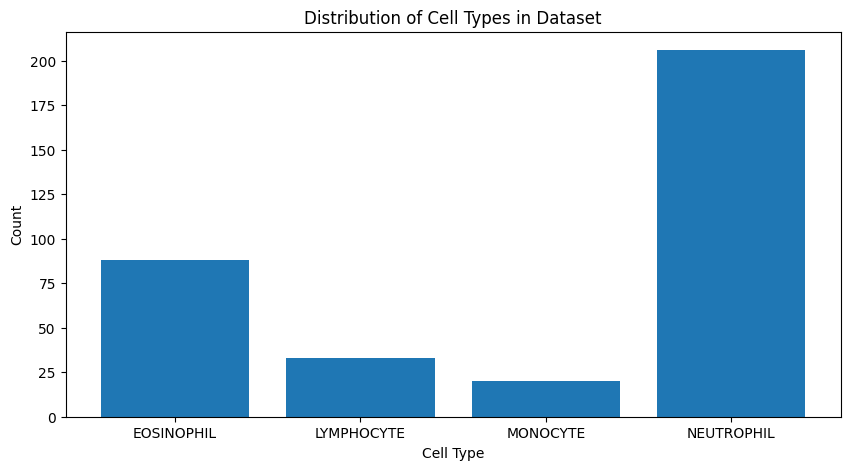

In [34]:
dataset.plot_label_distribution()